In [1]:
%matplotlib notebook
import beamsolve as bs
from beam_solver import beamsolve as bs
from beam_solver import beam_utils as bt
from beam_solver import catdata as cd
from beam_solver.data import DATA_PATH
import numpy as np
import pylab
import glob
import pickle
import h5py
import os

## Loading right ascension and declination values and fitsfiles for xx and yy polarizations

In [2]:
fitsfiles_xx = glob.glob('/Users/Ridhima/Documents/ucb_projects/beam_characterization/smooth/2458115.*.xx.fits')
fitsfiles_xx = sorted(fitsfiles_xx)

In [3]:
fitsfiles_yy = glob.glob('/Users/Ridhima/Documents/ucb_projects/beam_characterization/smooth/2458115.*.yy.fits')
fitsfiles_yy = sorted(fitsfiles_yy)

In [4]:
srcdict_xx = pickle.load(open('/Users/Ridhima/Documents/ucb_projects/beam_characterization/scripts/srcdict_xx.pkl'))
ras_xx = srcdict_xx['ra']
decs_xx = srcdict_xx['dec']

srcdict_yy = pickle.load(open('/Users/Ridhima/Documents/ucb_projects/beam_characterization/scripts/srcdict_yy.pkl'))
ras_yy = srcdict_yy['ra']
decs_yy = srcdict_yy['dec']

## Generating catalogs for xx and yy polarizations

In [5]:
catd_xx = cd.catData()
srcdict_xx = catd_xx.gen_catalog(fitsfiles_xx, ras_xx, decs_xx, return_data=True)

/Users/Ridhima/software/anaconda2/lib/python2.7/site-packages/beam_solver-0.1.0-py2.7.egg/beam_solver/extract.py:149: Warning: WARNING: Right ascension or declination outside image field, therefore values are set to nan
  warnings.warn('WARNING: Right ascension or declination outside image field, therefore values are set to nan', Warning)


In [6]:
catd_yy = cd.catData()
srcdict_yy = catd_yy.gen_catalog(fitsfiles_yy, ras_yy, decs_yy, return_data=True)

## Writing to disk

In [8]:
catd_xx.write_hdf5('srcd_xx.h5')
catd_yy.write_hdf5('srcd_yy.h5')

## Calculating corrected flux values

In [10]:
beamfits = os.path.join(DATA_PATH, 'HERA_NF_dipole_power.beamfits')
beam_xx = bt.get_fitsbeam(beamfits, 151e6, 'xx')
corrflux_xx = catd_xx.calc_corrflux(beam_xx, 'xx')

beam_yy = bt.get_fitsbeam(beamfits, 151e6, 'yy')
corrflux_yy = catd_yy.calc_corrflux(beam_yy, 'yy')

Casting complex values to real discards the imaginary part


## Constructing primary beam 

In [33]:
bms_xx = bs.BeamSolveBase(cat=catd_xx)
bms_xx.construct_linear_sys(mflux = corrflux_xx)
sol_xx = bms_xx.solve(solver='Linear')

Solving 0/1
Time Elapsed: 0.89 seconds


In [34]:
bms_yy = bs.BeamSolveBase(cat=catd_yy)
bms_yy.construct_linear_sys(mflux = corrflux_yy)
sol_yy = bms_yy.solve(solver='Linear')

Solving 0/1
Time Elapsed: 0.73 seconds


In [35]:
obsbeam_xx = bs.eval_linear_sol(sol_xx, 60)
obsbeam_yy = bs.eval_linear_sol(sol_yy, 60)

<IPython.core.display.Javascript object>


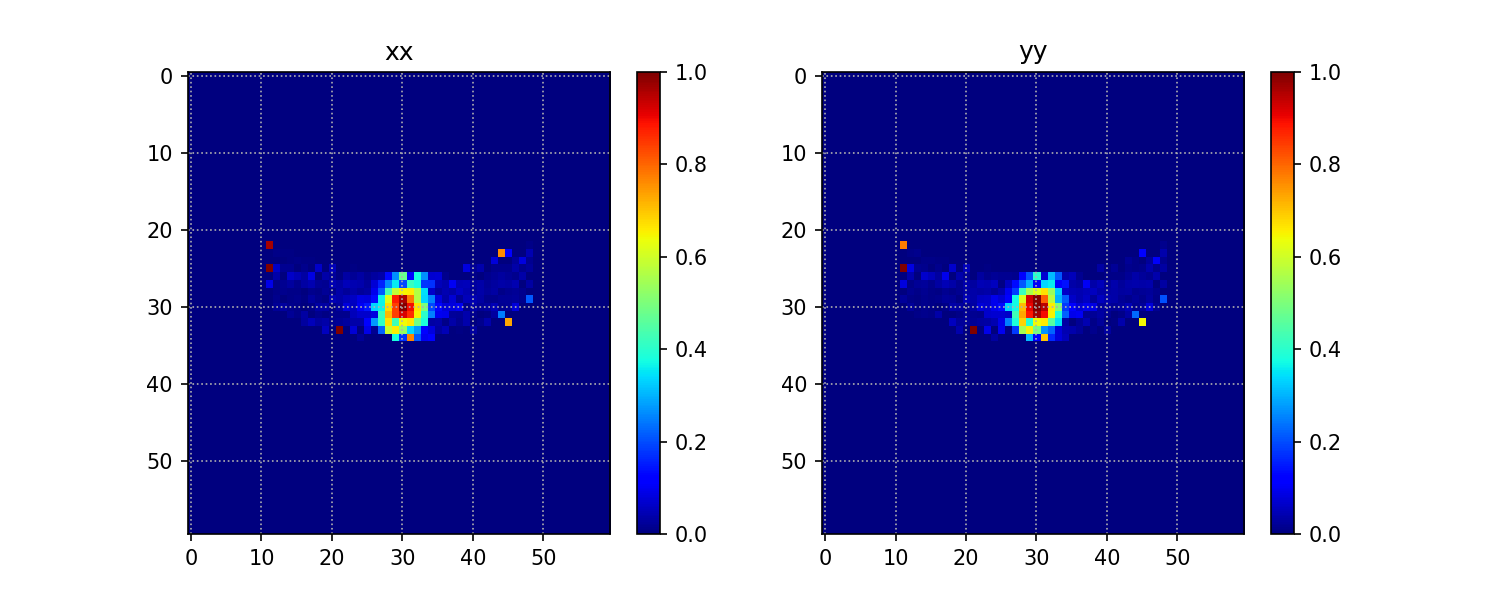

In [36]:
pylab.figure(figsize=(10,4))
pylab.subplot(121)
pylab.title('xx')
pylab.imshow(obsbeam_xx.T, aspect='auto', cmap='jet', vmin=0, vmax=1.0)
pylab.colorbar()
pylab.grid(ls='dotted')

pylab.subplot(122)
pylab.title('yy')
pylab.imshow(obsbeam_yy.T, aspect='auto', cmap='jet', vmin=0, vmax=1.0)
pylab.colorbar()
pylab.grid(ls='dotted')

Removing degenerated modes

Removing all eigen modes above 328
Removing all eigen modes above 328


<IPython.core.display.Javascript object>


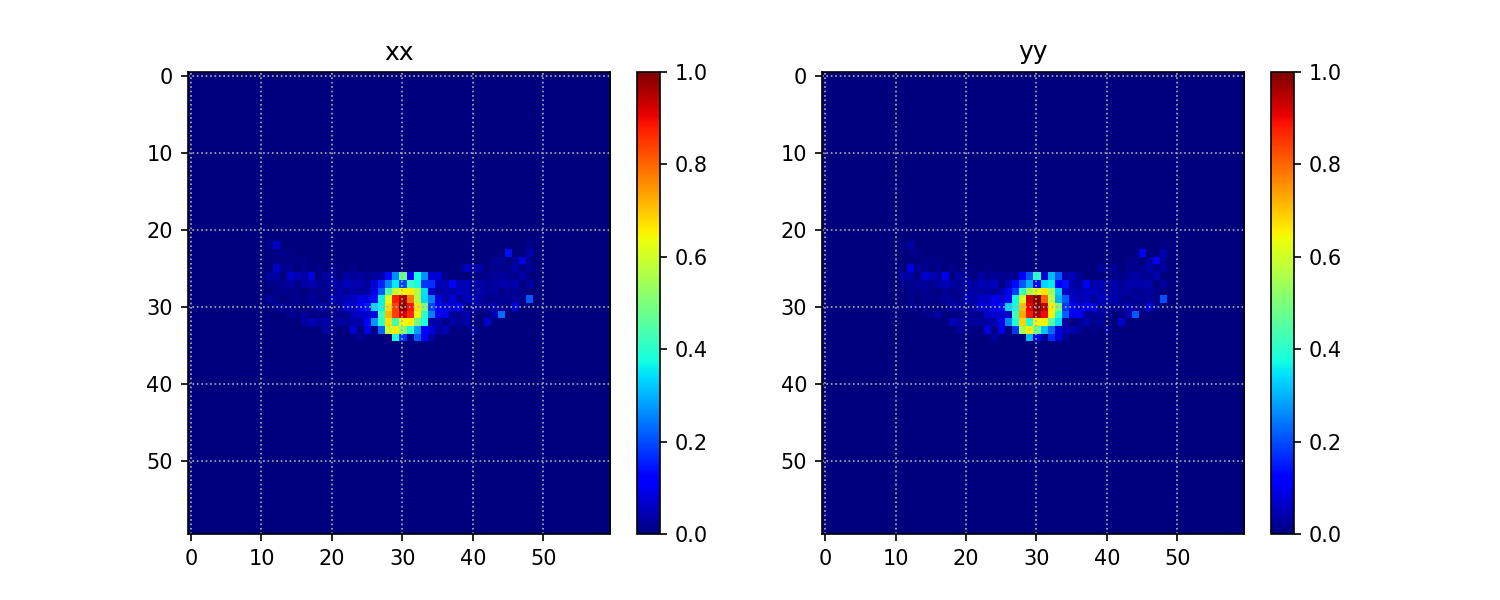

In [37]:
obsbeam_xx = bs.remove_degen(bms_xx.ls, obsbeam_xx, 60, threshold=0.0004)
obsbeam_yy = bs.remove_degen(bms_yy.ls, obsbeam_yy, 60, threshold=0.0004)

pylab.figure(figsize=(10,4))
pylab.subplot(121)
pylab.title('xx')
pylab.imshow(obsbeam_xx.T, aspect='auto', cmap='jet', vmin=0, vmax=1.0)
pylab.colorbar()
pylab.grid(ls='dotted')

pylab.subplot(122)
pylab.title('yy')
pylab.imshow(obsbeam_yy.T, aspect='auto', cmap='jet', vmin=0, vmax=1.0)
pylab.colorbar()
pylab.grid(ls='dotted')

## Constructing beam using cross polarizations 

In [21]:
catd = cd.catData()
srcdict = catd.gen_polcatalog(fitsfiles_xx, fitsfiles_yy, ras_xx, decs_xx, return_data=True)

In [23]:
beam_xx = bt.get_fitsbeam(beamfits, 151e6, 'xx')
corrflux_xx = catd.calc_corrflux(beam_xx, 'xx')

beam_yy = bt.get_fitsbeam(beamfits, 151e6, 'yy')
corrflux_yy = catd.calc_corrflux(beam_yy, 'yy')

In [24]:
catd.write_hdf5('polsrcd.h5', clobber=True)

Overwriting existing file.


In [51]:
bms = bs.BeamSolveCross(cat=catd)
bms.construct_linear_sys(mflux_xx = corrflux_xx, mflux_yy = corrflux_yy, theta_xx=[0], theta_yy=[np.pi/2], flip=[1, -1])
sol = bms.solve(solver='Linear')

Solving 0/1
Time Elapsed: 3.88 seconds


<IPython.core.display.Javascript object>


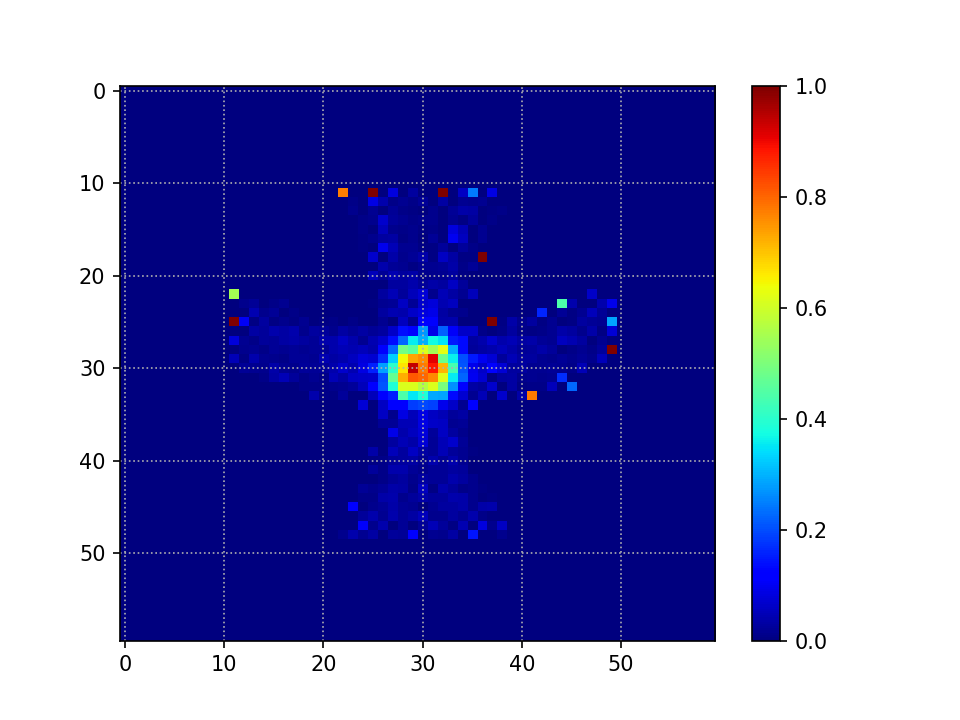

In [52]:
obsbeam = bs.eval_linear_sol(sol, 60)
pylab.subplot(111)
pylab.imshow(obsbeam.T, aspect='auto', cmap='jet', vmin=0, vmax=1.0)
pylab.colorbar()
pylab.grid(ls='dotted')